In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bdm-2021-face/622110140_4_0.jpg
/kaggle/input/bdm-2021-face/612110186_1_1.jpg
/kaggle/input/bdm-2021-face/622110172_1_0.jpg
/kaggle/input/bdm-2021-face/622110154_1_0.jpg
/kaggle/input/bdm-2021-face/602110088_1_0.jpg
/kaggle/input/bdm-2021-face/622110206_4_0.jpg
/kaggle/input/bdm-2021-face/602110088_2_0.jpg
/kaggle/input/bdm-2021-face/622110240_4_0.jpg
/kaggle/input/bdm-2021-face/612110159_3_0.jpg
/kaggle/input/bdm-2021-face/622110210_2_0.jpg
/kaggle/input/bdm-2021-face/612110174_4_0.jpg
/kaggle/input/bdm-2021-face/612110185_1_1.jpg
/kaggle/input/bdm-2021-face/622110140_2_0.jpg
/kaggle/input/bdm-2021-face/622110174_2_1.jpg
/kaggle/input/bdm-2021-face/612110186_2_1.jpg
/kaggle/input/bdm-2021-face/622110172_3_0.jpg
/kaggle/input/bdm-2021-face/622110140_1_0.jpg
/kaggle/input/bdm-2021-face/622110174_3_1.jpg
/kaggle/input/bdm-2021-face/612110174_1_0.jpg
/kaggle/input/bdm-2021-face/602110088_3_0.jpg
/kaggle/input/bdm-2021-face/622110222_2_1.jpg
/kaggle/input/bdm-2021-face/622110

# **Preprocessing**

In [52]:
import glob 
filename = glob.glob("/kaggle/input/bdm-2021-face/*.*") 

In [53]:
filename[0].split("_")

['/kaggle/input/bdm-2021-face/622110140', '4', '0.jpg']

0 Male
1 Female

In [54]:
label = np.array([float(item.split("_")[-1].split(".")[0]) for item in filename]) #ดึงค่า label เพศของแต่ละรูปออกมาโดยใช้ split
label

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [55]:
#create directory (folder)
!mkdir train
!mkdir train/male
!mkdir train/female

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train/male’: File exists
mkdir: cannot create directory ‘train/female’: File exists


In [56]:
!mkdir test
!mkdir test/male
!mkdir test/female

mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘test/male’: File exists
mkdir: cannot create directory ‘test/female’: File exists


In [57]:
#!rm -rf test/female/*  

0 Male
1 Female

In [58]:
#copy file to directory train/male & tain/female
import shutil
for i in range(len(label)):
    if label[i] == 0:
        shutil.copy(filename[i], '/kaggle/working/train/male/')
    else:
        shutil.copy(filename[i], '/kaggle/working/train/female/')

In [59]:
import glob
filemale = np.array(glob.glob("./train/male/*.*"))
filefemale = np.array(glob.glob("./train/female/*.*"))

In [60]:
#สุ่มไป directory test
rng = np.random.RandomState(0)
midx = np.random.randint(len(filemale), size=4)
fidx = np.random.randint(len(filefemale), size=2)

In [61]:
#ย้าย filename ที่สุ่มมาไปไว้ใน directory test
for i in fidx:
    shutil.move(filefemale[i],'./test/female')
for i in midx:
    shutil.move(filemale[i],'./test/male')

# **CNN**

In [62]:
#Images Augumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        #rescale = 1.0/255.0,   # Intensity Normalized
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180) #หมุนภาพ
        zoom_range = 0.2, # Randomly zoom image #ซูมภาพ
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        validation_split=0.2) #แบ่่ง validation ไปใช้ใน deep learning 

In [63]:
#data generator
batch_size = 5 #เอาเข้าไปเทรนที่ละ 5 ภาพ
img_height = 100 #ภาพต้องขนาดเท่ากัน
img_width  = 100 #ภาพต้องขนาดเท่ากัน
train_dir = './train'

#train set
train_generator = data_generator.flow_from_directory(
    train_dir ,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', # label มีสองกลุ่มคือ dog กับ cat
    subset='training') # set as training data

#validation set
validation_generator = data_generator.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', # label มีสองกลุ่มคือ dog กับ cat
    subset='validation') # set as validation data

Found 63 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [64]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
# preparing the layers in the Convolutional Deep Neural Network

def create_model():
    tf.random.set_seed(0)
    tf.compat.v1.reset_default_graph() # Clear Model
    #แบ่ง layers 
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = train_generator.image_shape)) #32 kernal ขนาด 3x3
    model.add(MaxPooling2D(pool_size = (2, 2))) 
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(rate = 0.15))
    
    model.add(Flatten()) #รวมให้กัน 1 features
    
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dense(units = 8, activation = 'relu'))
    model.add(Dense(units = 4, activation = 'relu'))
    model.add(Dense(units = 2, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [66]:
model = create_model()
fitted_model = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 100)

Epoch 1/100
12/12 [==============================] - 6s 439ms/step - loss: 0.6631 - accuracy: 0.7444 - val_loss: 0.5720 - val_accuracy: 0.8000
Epoch 2/100
12/12 [==============================] - 4s 387ms/step - loss: 0.4751 - accuracy: 0.8783 - val_loss: 0.5885 - val_accuracy: 0.8000
Epoch 3/100
12/12 [==============================] - 4s 367ms/step - loss: 0.5344 - accuracy: 0.7729 - val_loss: 0.5173 - val_accuracy: 0.8000
Epoch 4/100
12/12 [==============================] - 5s 402ms/step - loss: 0.4310 - accuracy: 0.8264 - val_loss: 0.4851 - val_accuracy: 0.8000
Epoch 5/100
12/12 [==============================] - 4s 383ms/step - loss: 0.4946 - accuracy: 0.7544 - val_loss: 0.5751 - val_accuracy: 0.8000
Epoch 6/100
12/12 [==============================] - 4s 354ms/step - loss: 0.4925 - accuracy: 0.7612 - val_loss: 0.5405 - val_accuracy: 0.8000
Epoch 7/100
12/12 [==============================] - 5s 429ms/step - loss: 0.4308 - accuracy: 0.7838 - val_loss: 0.4546 - val_accuracy: 0.8000

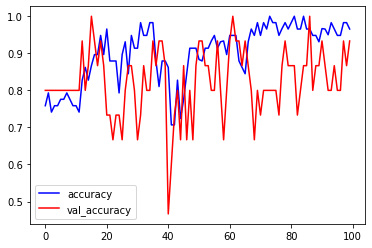

In [67]:
import matplotlib.pyplot as plt
# plotting accuracy and validation accuracy
accuracy = fitted_model.history['accuracy']
val_accuracy = fitted_model.history['val_accuracy']
plt.plot(range(len(accuracy)), accuracy, 'b-', label = 'accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'r-', label = 'val_accuracy')
plt.legend()

In [71]:
import glob 
filefemale = glob.glob("./test/female/*.jpg")
filemale = glob.glob("./test/male/*.jpg")

In [75]:
from tensorflow.keras.preprocessing import image
# testing the model
plabel = []
for filename in filefemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
    
#female accuracy
plabel = np.array(plabel)
sum(plabel==0)/len(plabel)

1.0

In [76]:
# testing the model
plabel = []
for filename in filemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
    
#male accuracy
plabel = np.array(plabel)
sum(plabel==1)/len(plabel)

1.0